# Pretraining on unlabeled data

This chapter covers training our model as well as using basic model evaluation techniques.

In [1]:
# Setting the previous LLM
import torch
from chapter04 import GPTModel

GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, # Reduced context length to just 256 tokens
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12,
 "drop_rate": 0.1,
 "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [2]:
# Functions for text to code
import tiktoken
from chapter04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
 """Converts texts to token ids"""
 encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
 # Converts TokenIds into a Pytorch tensor
 encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
 return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
 "Changes ids to text"
 flat = token_ids.squeeze(0)
 return tokenizer.decode(flat.tolist()) # Converts back into text

# Sample text
start_context = "Every effort moves you"
# Initializes tokenizer
tokenizer = tiktoken.get_encoding("gpt2")
# Obtains the Token IDs
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(start_context, tokenizer),
 max_new_tokens=10,
 context_size=GPT_CONFIG_124M["context_length"]
)
# Final generated text
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


As the generated text does not make any sense we have to train it, but first we will create a loss function to evaluate our model.

**Text generation loss**

In [3]:
import torch
# Starting with a brief example
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
 [40, 1107, 588]]) # "I really like"]

# Targets are inputs shifted one position forward
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
 [1107, 588, 11311]]) # " really like chocolate"]

# Porviding the input to our model
with torch.no_grad(): # No training yet
 logits = model(inputs) # Output

probas = torch.softmax(logits, dim=-1) # Softmax
print(probas.shape)
# First number is the batch -> 2 (two example in the input)
# Second number is the number of tokens -> 3 (tokens in each input )
# Last number is the embedding dimensionality

# Obtaining best values
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
# Outputs one value per input token
print("Token IDs:\n", token_ids)

# Decoding the tokens
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
 f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")


# Obtaining the respective probabilities
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

# We want to maximize the likelihood of the correct word appearing, which in other terms also means having a higher 
# probability with respect to other words

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


General structure for computing the loss


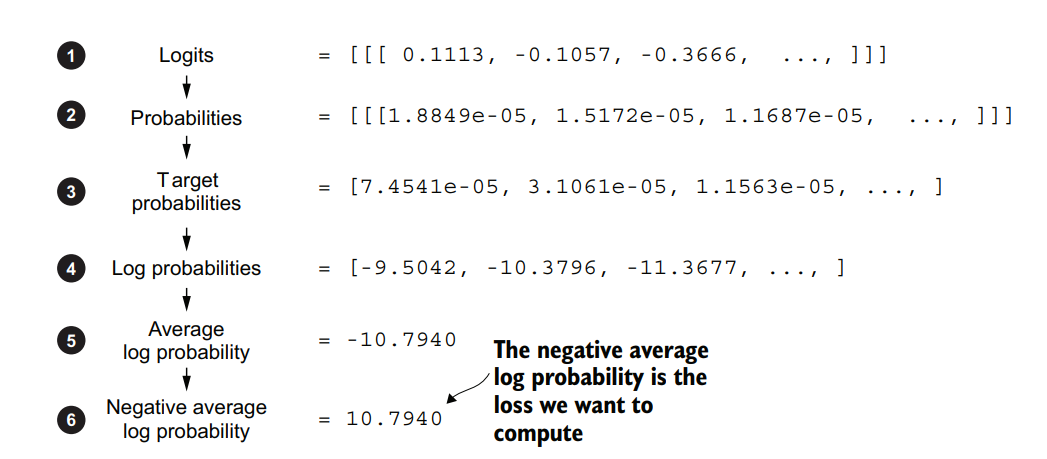

Logarithms are used due to their differentiability, they also dont make small numbers not vanish, as well as changing multiplications to sums

In [4]:
# We will proceed computing the logs
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print("Log probabilities: ",log_probas)

# Obtainin the mean
avg_log_probas = torch.mean(log_probas)
print("Mean: ", avg_log_probas) # We want this number to be close to 0

# Negative average, for optimization as most optimizers find minimums
neg_avg_log_probas = avg_log_probas * -1 # Also known as cross entropy

Log probabilities:  tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
Mean:  tensor(-10.7940)


In [5]:
# Applying cross entropy 
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

# We need to flatten them for the function
logits_flat = logits.flatten(0, 1) # Unscaled output
targets_flat = targets.flatten() # Toekns we want the model to generate
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

# Cross-entropy function
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Loss: ",loss)

# Perplexity
# Compares the predicted probability distribution to see if it matches the actual distribution of the words in the dataset.
# In this case, it defines the amount of elements in the vocabulary the model is unsure to generate next
perplexity = torch.exp(loss)
print("Perplexity: ", perplexity) # Unsure about 48725 words

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])
Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
Loss:  tensor(10.7940)
Perplexity:  tensor(48725.8203)


**Calculating training and validation losses**

In [6]:
# Using the Verdict txt file
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
 text_data = file.read()

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)
# Simple text just to have a good view of what we are dealing with

Characters: 20479
Tokens: 5145


In [7]:
# Splitting into testing and training
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# Using our previously created dataloaders
from chapter02 import create_dataloader_v1
torch.manual_seed(123)


train_loader = create_dataloader_v1(
 train_data,
 batch_size=2, # Small batch size due to how short our text is
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=True,
 shuffle=True,
 num_workers=0
)

val_loader = create_dataloader_v1(
 val_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=False,
 shuffle=False,
 num_workers=0
)

print("Train loader:")
for x, y in train_loader:
 print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
 print(x.shape, y.shape)

# 9 training set batches 

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


**Loss functions**

In [18]:
# Cross entropy loss of a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
 """ Input batch: batch of input data
 target batch: labels we wish to predict
 model: NN model
 device: CPU or GPU"""
 
 # Used more commonly for GPU
 input_batch = input_batch.to(device)
 target_batch = target_batch.to(device)

 # Output
 logits = model(input_batch)

 # Loss
 loss = torch.nn.functional.cross_entropy(
 logits.flatten(0, 1), target_batch.flatten()
 )
 return loss

# Loss over all batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
 """ data_loader: DataLoader for providing batches of input
 model: evaluated model
 device: CPU or GPU
 num_batches: batches used to compute loss, if None, all batches are used"""
 
 # Initalize loss
 total_loss = 0.

 # Empty data
 if len(data_loader) == 0:
    return float("nan")
 
 # Define batches used
 elif num_batches is None:
    num_batches = len(data_loader)
 else:
    num_batches = min(num_batches, len(data_loader))
 # Loop over data, for each batch
 for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch( # COmputes loss
               input_batch, target_batch, model, device)
            total_loss += loss.item() # Adds the loss
        else:
            break

 # Returns average loss
 return total_loss / num_batches 

In [19]:
import torch
# Testing our code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU if available
model.to(device)

# No training yet
with torch.no_grad():
 train_loss = calc_loss_loader(train_loader, model, device)
 val_loss = calc_loss_loader(val_loader, model, device)
 
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 6.082557837168376
Validation loss: 6.61604118347168


The loss is really high, however, the model has yet to be trained

**Training**

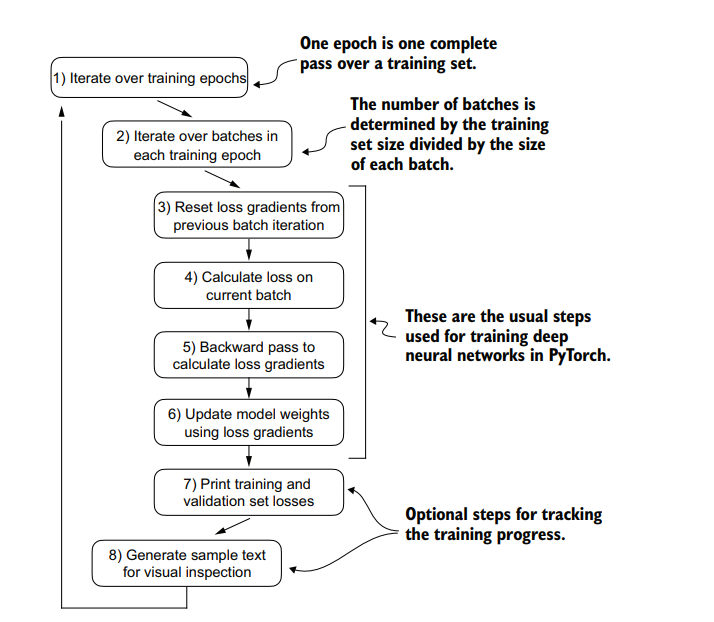



In [21]:
# Training function
def train_model_simple(model, train_loader, val_loader,
 optimizer, device, num_epochs,
 eval_freq, eval_iter, start_context, tokenizer):
 """Function for training LLM model
 model: chosen NN model
 train_loader: DataLoader for training
 val_loader: DataLoader for testing
 optimizer: Optimization algorithm
 device: CPU or GPU
 num_epochs: amount of full passes through all data
 eval_freq: frequency of loss evaluation
 eval_iter: how many batches per evaluation
 start_context: Initial context prompt
 tokenizer: Model output into readable tokens"""

 # Initialize lists to track losses and seen tokens
 train_losses, val_losses, track_tokens_seen = [], [], []
 tokens_seen, global_step = 0, -1

 # Main training loop
 for epoch in range(num_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Resets gradients

        # Calculates loss
        loss = calc_loss_batch(
        input_batch, target_batch, model, device
        )

        loss.backward() # Loss gradients
        optimizer.step() # Updates model weights
        tokens_seen += input_batch.numel() # TOtal tokens
        global_step += 1 # Taken update steps

        # Evaluate model periodically
        if global_step % eval_freq == 0:
            # Obtain loss
            train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter)
            # Store loss and values
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            track_tokens_seen.append(tokens_seen)
            print(f"Ep {epoch+1} (Step {global_step:06d}): "
            f"Train loss {train_loss:.3f}, "
            f"Val loss {val_loss:.3f}"
            )

    # Sample text after each epoch
    generate_and_print_sample(
    model, tokenizer, device, start_context)


 return train_losses, val_losses, track_tokens_seen


# Implementing the required functions

# Prints training and validation losses to update them
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
 
 model.eval() # Dropout disappears
 
 with torch.no_grad(): # Evaluation is done, no need for gradients
    train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=eval_iter
    )
    val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=eval_iter
    )
 model.train() # Train the model
 return train_loss, val_loss

# Generates a text to validate its performance during training
def generate_and_print_sample(model, tokenizer, device, start_context):
 model.eval() # No training, just word generation
 context_size = model.pos_emb.weight.shape[0] # Maximum available context length
 encoded = text_to_token_ids(start_context, tokenizer).to(device) # Tokenizing text
 with torch.no_grad():
    token_ids = generate_text_simple(
    model=model, idx=encoded,
    max_new_tokens=50, context_size=context_size) # Generates 50 new tkens

 decoded_text = token_ids_to_text(token_ids, tokenizer) # Decoded tokens
 print(decoded_text.replace("\n", " "))
 model.train() # Back to training

**Optimizers**

We will use Adam optimizers, more specifically AdamW , which aims to minimize model complexity and
prevent overfitting by penalizing larger weights.

AdamW combines Adam optimizer which adjusts learning rate for each parameter using the first two moments, and weight decay which discourages large weights adding a penalty to the loss.

In [22]:
# Simple training
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M) # Intializes model
model.to(device)
optimizer = torch.optim.AdamW( # Initializes optimizer
 model.parameters(),
 lr=0.0004, weight_decay=0.1
)
num_epochs = 10 # Number of epochs
train_losses, val_losses, tokens_seen = train_model_simple( # Training loop
 model, train_loader, val_loader, optimizer, device,
 num_epochs=num_epochs, eval_freq=5, eval_iter=5,
 start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

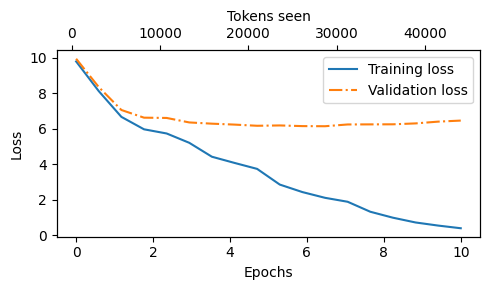

In [27]:
# Plot for visualizing loss and training
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
 fig, ax1 = plt.subplots(figsize=(5, 3))
 ax1.plot(epochs_seen, train_losses, label="Training loss")
 ax1.plot(
 epochs_seen, val_losses, linestyle="-.", label="Validation loss"
 )
 ax1.set_xlabel("Epochs")
 ax1.set_ylabel("Loss")
 ax1.legend(loc="upper right")
 ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
 ax2 = ax1.twiny()
 ax2.plot(tokens_seen, train_losses, alpha=0)
 ax2.set_xlabel("Tokens seen")
 fig.tight_layout()
 plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

There is a clear overfitting as the divergence of the losses show. Training loss improves drastically contrary to validation loss which does not seem to decrease as much.

This is due to our small dataset as well as that we have used many epochs.

**Strategies to reduce memorization**

Two techniques used to improve this function are temperature scaling and top-k sampling. They are used for controlling randomness and diversity.

Temperature Scaling controls the randomness by scaling the logits before applying softmax

The logits are divided by the temperature which can lead to more diverse texts.

Temperatures greater than 1 result in more uniformly distributed token probabilities,
and temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions

Top-k sampling keeps the k first highest probability tokens and sets the remaining to 0, making the model focus more while still providing variety.

Both of these strategies are usually combined to obtain the best benefits from both of them


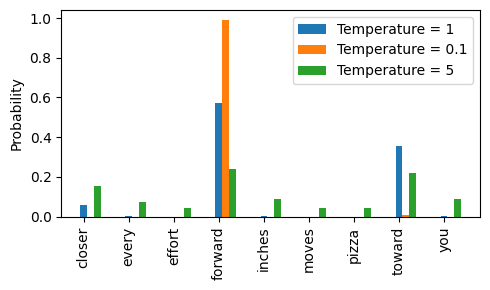

In [ ]:
# Temperature Scaling
def softmax_with_temperature(logits, temperature):
 scaled_logits = logits / temperature
 return torch.softmax(scaled_logits, dim=0)

# Short example
vocab = {
 "closer": 0,
 "every": 1,
 "effort": 2,
 "forward": 3,
 "inches": 4,
 "moves": 5,
 "pizza": 6,
 "toward": 7,
 "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

next_token_logits = torch.tensor(
 [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
# The next word will more than likely be forward


# Temperature scaling
temperatures = [1, 0.1, 5]
# Probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T)
for T in temperatures]
x = torch.arange(len(vocab))

# Plotting the results
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
 rects = ax.bar(x + i * bar_width, scaled_probas[i],
 bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

Low temperatures will lead to selecting the most common words most of the times

On the other hand, higher temperatures lead to more variety although they can cause sentences which do not make much sense.

Temperature 1 is the same as not doing anything.

In [31]:
# Top k approach
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

# Setting the remaining to -Inf
new_logits = torch.where(
 condition=next_token_logits < top_logits[-1],
 input=torch.tensor(float('-inf')),
 other=next_token_logits
)
print("Outputs top-k",new_logits)

# Changing to probabilities
topk_probas = torch.softmax(new_logits, dim=0)
print("Probabilities: ",topk_probas)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
Outputs top-k tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
Probabilities:  tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


To select the desired token out of the k chosen ones, we will change the text generation function


In [43]:
def generate(model, idx, max_new_tokens, context_size,
 temperature=0.0, top_k=None, eos_id=None):
 # Same for loop as before
 for _ in range(max_new_tokens):
   idx_cond = idx[:, -context_size:]
   with torch.no_grad():
        logits = model(idx_cond)
        logits = logits[:, -1, :]
 
   # Top_k strategy
   if top_k is not None:
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1]
      logits = torch.where(
      logits < min_val,
      torch.tensor(float('-inf')).to(logits.device),
      logits
      )
   # Temperature scaling
   if temperature > 0.0:
      logits = logits / temperature
      probs = torch.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
   else:
      # Greedy token selection if temperature is not used
      idx_next = torch.argmax(logits, dim=-1, keepdim=True)

   if idx_next == eos_id: # If end of sequence found, stops generating
      break
   idx = torch.cat((idx, idx_next), dim=1)
 return idx

In [45]:
torch.manual_seed(123)
token_ids = generate(
 model=model,
 idx=text_to_token_ids("Every effort moves you", tokenizer),
 max_new_tokens=15,
 context_size=GPT_CONFIG_124M["context_length"],
 top_k=25,
 temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youlit terrace.



" he said deprecating laugh


**Loading and Saving model weights**

As training LLM is computationally expensive, we have to save it to avoid rerunning the training done on our model.

In [47]:
# Saving a model for inference
#torch.save(model.state_dict(), "model.pth")

# Loading the model
#model = GPTModel(GPT_CONFIG_124M)
#model.load_state_dict(torch.load("model.pth", map_location=device))
#model.eval()

# If we want to store for futrue training
torch.save({
 "model_state_dict": model.state_dict(),
 "optimizer_state_dict": optimizer.state_dict(),
 },
 "model_and_optimizer.pth"
)

# Loading
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

**Loading pretrained weights**

GPT 2 has open shared weights of their models which can be used for training.

We will have to install TensorFlow and tqdm


In [ ]:
# pip install tensorflow>=2.15.0 tqdm>=4.66

# Downloading code from the github of the book
import urllib.request
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)



('gpt_download.py', <http.client.HTTPMessage at 0x1ec1884c0d0>)

In [50]:
# Smallest GPT2 models
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
 model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 17.8kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.05MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 29.7kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [03:38<00:00, 2.28MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 1.31MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 552kiB/s] 
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 591kiB/s] 


In [52]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [51]:
# Initializing the smaller model
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
# Bigger token length
NEW_CONFIG.update({"context_length": 1024})
# Old model used to work with bias
NEW_CONFIG.update({"qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

As the GPT model intializes random weights, we want to avoid this as we have preloaded weights. To manually assign this we will use a function which ensures the parameters have the right shape and they can be used as a Pytorch trainable parameter.

In [53]:
def assign(left, right):
 if left.shape != right.shape:
    raise ValueError(f"Shape mismatch. Left: {left.shape}, "
 "Right: {right.shape}"
 )
 return torch.nn.Parameter(torch.tensor(right))


The following function loads pretrained weights from params into a custom gpt model.

In [ ]:
# Loading weights into the gpt
import numpy as np

def load_weights_into_gpt(gpt, params):
 gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
 gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

 for b in range(len(params["blocks"])):
    q_w, k_w, v_w = np.split(
    (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.weight = assign(
    gpt.trf_blocks[b].att.W_query.weight, q_w.T)
    gpt.trf_blocks[b].att.W_key.weight = assign(
    gpt.trf_blocks[b].att.W_key.weight, k_w.T)
    gpt.trf_blocks[b].att.W_value.weight = assign(
    gpt.trf_blocks[b].att.W_value.weight, v_w.T)
    q_b, k_b, v_b = np.split(
    (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
    gpt.trf_blocks[b].att.W_query.bias = assign(
    gpt.trf_blocks[b].att.W_query.bias, q_b)
    gpt.trf_blocks[b].att.W_key.bias = assign(
    gpt.trf_blocks[b].att.W_key.bias, k_b)
    gpt.trf_blocks[b].att.W_value.bias = assign(
    gpt.trf_blocks[b].att.W_value.bias, v_b)
    gpt.trf_blocks[b].att.out_proj.weight = assign(
    gpt.trf_blocks[b].att.out_proj.weight,
    params["blocks"][b]["attn"]["c_proj"]["w"].T)

    gpt.trf_blocks[b].att.out_proj.bias = assign(
    gpt.trf_blocks[b].att.out_proj.bias,
    params["blocks"][b]["attn"]["c_proj"]["b"])
    gpt.trf_blocks[b].ff.layers[0].weight = assign(
    gpt.trf_blocks[b].ff.layers[0].weight,
    params["blocks"][b]["mlp"]["c_fc"]["w"].T)
    gpt.trf_blocks[b].ff.layers[0].bias = assign(
    gpt.trf_blocks[b].ff.layers[0].bias,
    params["blocks"][b]["mlp"]["c_fc"]["b"])
    gpt.trf_blocks[b].ff.layers[2].weight = assign(
    gpt.trf_blocks[b].ff.layers[2].weight,
    params["blocks"][b]["mlp"]["c_proj"]["w"].T)
    gpt.trf_blocks[b].ff.layers[2].bias = assign(
    gpt.trf_blocks[b].ff.layers[2].bias,
    params["blocks"][b]["mlp"]["c_proj"]["b"])
    gpt.trf_blocks[b].norm1.scale = assign(
    gpt.trf_blocks[b].norm1.scale,
    params["blocks"][b]["ln_1"]["g"])
    gpt.trf_blocks[b].norm1.shift = assign(
    gpt.trf_blocks[b].norm1.shift,
    params["blocks"][b]["ln_1"]["b"])
    gpt.trf_blocks[b].norm2.scale = assign(
    gpt.trf_blocks[b].norm2.scale,
    params["blocks"][b]["ln_2"]["g"])
    gpt.trf_blocks[b].norm2.shift = assign(
    gpt.trf_blocks[b].norm2.shift,
    params["blocks"][b]["ln_2"]["b"])

 gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
 gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
 gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [55]:
# Testing our code
load_weights_into_gpt(gpt, params)
gpt.to(device)

torch.manual_seed(123)
token_ids = generate(
 model=gpt,
 idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
 max_new_tokens=25,
 context_size=NEW_CONFIG["context_length"],
 top_k=50,
 temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




We see that our model works correctly.

**Summary**

 When LLMs generate text, they output one token at a time.

 By default, the next token is generated by converting the model outputs into
probability scores and selecting the token from the vocabulary that corresponds
to the highest probability score, which is known as “greedy decoding.”

 Using probabilistic sampling and temperature scaling, we can influence the
diversity and coherence of the generated text.

 Training and validation set losses can be used to gauge the quality of text generated by LLM during training

 Pretraining an LLM involves changing its weights to minimize the training loss.

 The training loop for LLMs itself is a standard procedure in deep learning,
using a conventional cross entropy loss and AdamW optimizer.

 Pretraining an LLM on a large text corpus is time- and resource-intensive, so we
can load openly available weights as an alternative to pretraining the model on
a large dataset ourselves.